In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import iv,kv
from scipy.constants import G
import scipy.stats as stats
import emcee
import corner

## Load the data

In [2]:
upper=np.array([14.16026862026862,
 76.23892214131884,
 92.7913607980966,
 106.72901772877847,
 125.57806026609369,
 140.2088888382753,
 168.23162643299915,
 193.5558969944813])

lower=np.array([75.75603101283859,
 91.35756281480651,
 106.50360827410432,
 125.49035925496432,
 139.92877144307616,
 167.9568980670359,
 193.11114932005125,
 369.36961022388766]
)

In [5]:
data=[]
for i in range(len(upper)):
    df=pd.read_csv('{mini}<V_opt<{maxi}_newest_filtered.csv'.format(mini=np.round(upper[i],2),maxi=np.round(lower[i],2)))
    data.append(df)
    
data[0]

,Unnamed: 0,r,v,err
0,0,0.080441,0.542010,0.032900
1,1,0.046616,0.329631,0.023018
2,2,0.015806,0.194635,0.021531
3,3,0.152201,0.794144,0.037478
4,4,0.187890,0.848025,0.033582
5,5,0.399634,1.217264,0.045347
6,6,0.333754,1.079954,0.037437
7,7,0.277019,1.049778,0.034056
8,8,0.229674,0.968590,0.037009
9,9,0.488444,1.315127,0.041120


<ErrorbarContainer object of 3 artists>

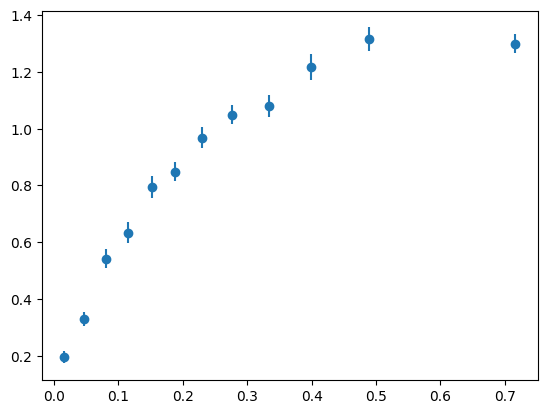

In [6]:
plt.errorbar(data[0]['r'],data[0]['v'],data[0]['err'],fmt='o')

In [7]:
vopts=np.array([53.11343513770514,
 82.9685285473563,
 99.75293258602721,
 115.85198036304831,
 133.26261104702695,
 153.62342263846637,
 179.67032624341968,
 240.85368998050632])
ropts=np.array([9.990073658142588,
 7.042543294166109,
 9.311675980435453,
 11.02302822693041,
 10.043588250265872,
 11.007484410893198,
 12.87485458483248,
 15.328049129568335])

In [8]:
df=pd.DataFrame({'Vopt':vopts,'RD':ropts/3})
df

,Vopt,RD
0,53.113435,3.330025
1,82.968529,2.347514
2,99.752933,3.103892
3,115.851980,3.674343
4,133.262611,3.347863
5,153.623423,3.669161
6,179.670326,4.291618
7,240.853690,5.109350


## Burkert

<ErrorbarContainer object of 3 artists>

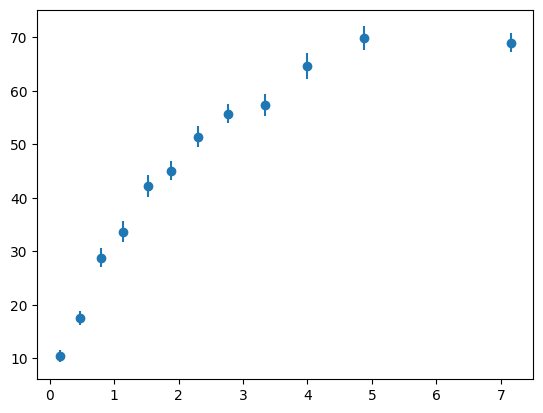

In [9]:
x=data[0]['r']*ropts[0]
y=data[0]['v']*vopts[0]
dy=data[0]['err']*vopts[0]
conv=3.086e19
plt.errorbar(x,y,dy,fmt='o')

In [27]:
def log_prior(theta,ropt,vopt):
    
    logmd, logp, rc = theta
    
    #Md in M_odot
    #p in g/cm3
    #rc in kpc
    
    
    if not ((7<logmd<11+np.log10(8)) and (0<rc<100) and (-20> logp > -26+np.log10(5))):
        return -np.inf
    
    return  0.0

In [11]:
def log_probability(theta, x, y, yerr,ropt,vopt):
    lp = log_prior(theta,ropt,vopt)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr,ropt,vopt)

In [12]:
def disk(theta,x, ropt,vopt):
    
    
    logmd,logp,rc=theta
    rx=1.5*(x/ropt)
    md=np.power(10,logmd)
    
    return (((2e24/(3.086e19))*G*md*(x)**2)/2/((ropt/3)**3))*(iv(0,rx)*kv(0,rx)-iv(1,rx)*kv(1,rx))

def burkert(theta,x, ropt,vopt):
    
    logmd,logp,rc=theta
    
    p=np.power(10,logp)
    if (any(x/rc) <-1):
        print (x,rc)
    
    return conv**2*1e-3*2*np.pi*p*(rc)**3*G/(x)*(np.log(1+(x/rc))-np.arctan(x/rc)+0.5*np.log(1+(x/rc)**2)) 


def model(theta,x, ropt,vopt):
    return np.sqrt(burkert(theta,x, ropt,vopt)+disk(theta,x, ropt,vopt))

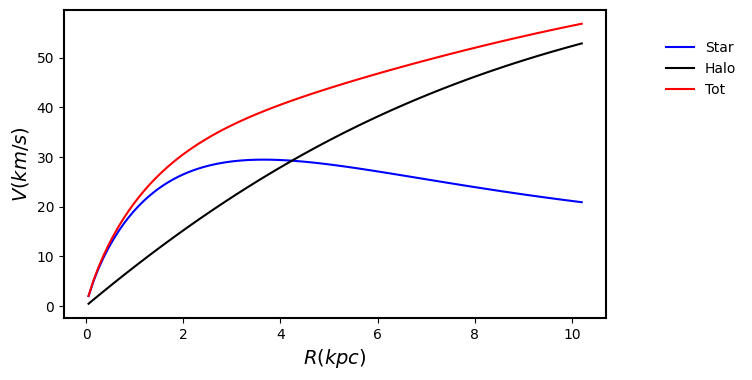

In [17]:
def check_disk(p0,rc,md,ropt,vopt):
    
    x=np.linspace(2*ropt,0.01*ropt,100)

    fig,ax=plt.subplots(figsize=(7,4))
    plt.plot(x,np.sqrt(disk(np.array([md,p0,rc]),x,ropt,vopt)),color='blue',label='Star')
    #plt.axvline(2.2)
    plt.plot(x,np.sqrt(burkert(np.array([md,p0,rc]),x,ropt,vopt)),color='black',label='Halo')
    plt.plot(x,np.sqrt(burkert(np.array([md,p0,rc]),x,ropt,vopt)
                      +disk(np.array([md,p0,rc]),x,ropt,vopt)),color='red',label='Tot')
   
    plt.legend(frameon=False,loc=(1.1,0.7))
    plt.xlabel('$R(kpc)$',fontsize=14,fontweight='bold')
    plt.ylabel('$V(km/s)$',fontsize=14,fontweight='bold')
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    
check_disk(np.log10(3.7*1e-3*2e33/(3.086e+16)**3/1e6),10.7,np.log10(8.8e+8),3*1.7,43.5)

In [18]:
def log_likelihood(theta, x, y, yerr,ropt,vopt):
    logmd,logp,logrc=theta
    ymodel = model(theta,x,ropt,vopt)
    return -0.5 * (np.sum((y - ymodel) ** 2 / (yerr**2))+np.sum(2*np.pi*yerr**2))

In [28]:
def main(x,y,yerr,ropt,vopt):
    
    
    p1=np.random.uniform(7,11+np.log10(8),25)
    #p2=np.random.uniform(5,11.5,25)
    p2=np.random.uniform(-20,-26+np.log10(5),25)
    p3=np.random.uniform(0,100,25)
    pos=np.vstack((p1,p2,p3)).T
    
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr,ropt,vopt))
    sampler.run_mcmc(pos, 5000, progress=True)
    
#    tau = sampler.get_autocorr_time()
    flat_samples = sampler.get_chain(discard=1000,thin=10, flat=True)
        
        
    return flat_samples

In [29]:
labels=[r'$logM_d$','$p$',r'$R_c$']
flat_samples=main(x,y,dy,ropts[0],vopts[0])

100%|███████████████████████████████████████| 5000/5000 [03:34<00:00, 23.36it/s]


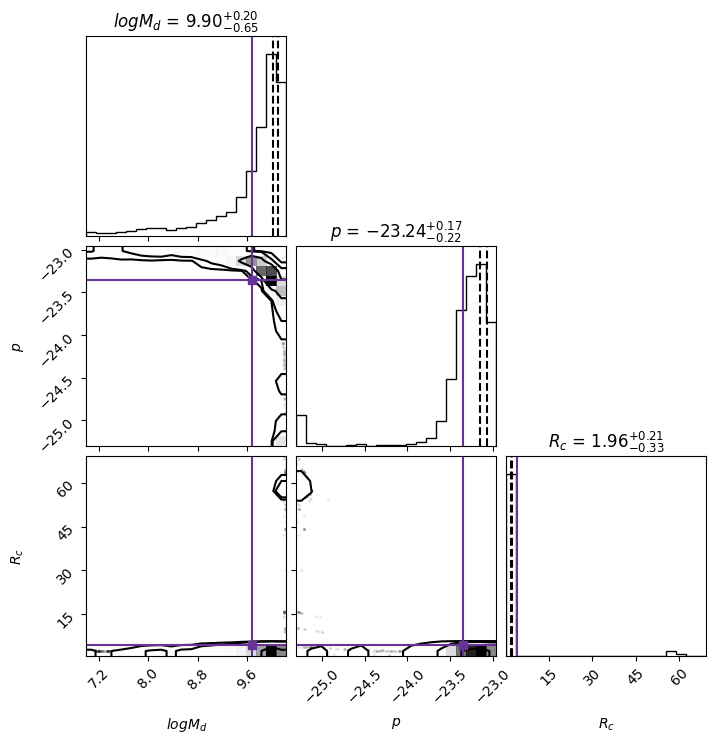

In [36]:
theta_max=np.mean(flat_samples,axis=0)
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))

In [ ]:
def plot_vels(no,theta_max):
    
    xplot=data[no]['r']*ropts[no]
    yplot=data[no]['v']*vopts[no]
    dyplot=data[no]['err']*vopts[no]
    x=np.linspace(max(xplot),min(xplot),100)

    fig,ax=plt.subplots(figsize=(5,4))
    plt.errorbar(xplot,yplot,dyplot,fmt='.',markersize=15,elinewidth=4,markerfacecolor='cornflowerblue', 
             markeredgecolor='black', ecolor='black',color='black',capsize=4,label='Data')
    plt.plot(x,model(theta_max,x,ropts[no],vopts[no]),linewidth=4,color='black',label='Model')
    plt.plot(x,np.sqrt(burkert(theta_max,x,ropts[no],vopts[no])),'--',color='red',label='Burkert Halo')
    #plt.plot(x,np.sqrt(bulge(theta_max,x,ropts[no],vopts[no])),color='pink',label='Bulge')
    plt.plot(x,np.sqrt(disk(theta_max,x,ropts[no],vopts[no])),color='blue',label='Disk')
    plt.title('Bin {}'.format(no+1))
    
    if no!=7:  
        plt.text(x=min(xplot)+0.05,y=max(model(theta_max,x,ropts[no],vopts[no]))-6,s='N=32',fontsize=12)
    else:
        plt.text(x=min(xplot)+0.05,y=max(model(theta_max,x,ropts[no],vopts[no]))-6,s='N=34',fontsize=12)
    plt.legend(frameon=False,loc=(1.1,0.7))
    plt.xlabel('$R(kpc)$',fontsize=14,fontweight='bold')
    plt.ylabel('$V(km/s)$',fontsize=14,fontweight='bold')
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    
plot_vels(0,theta_max)

100%|███████████████████████████████████████| 5000/5000 [03:05<00:00, 26.94it/s]


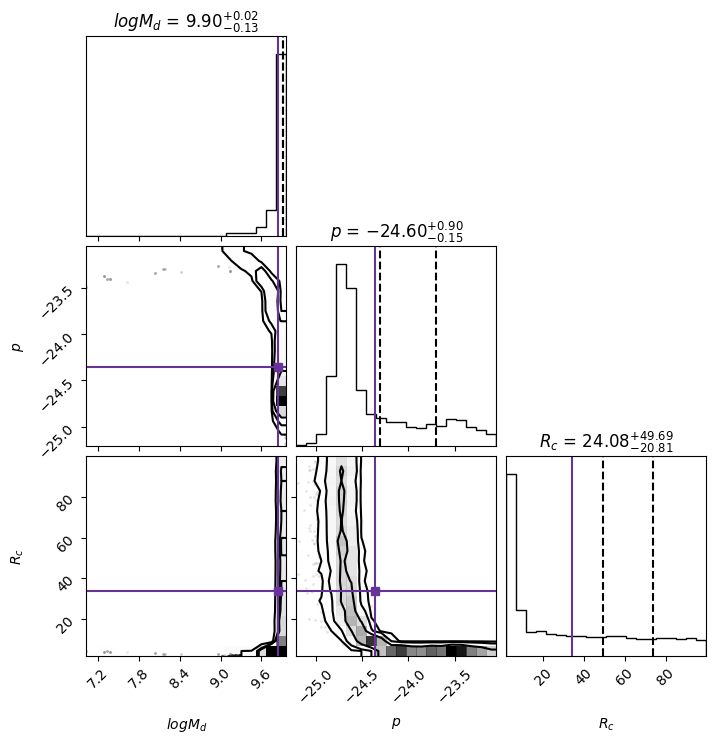

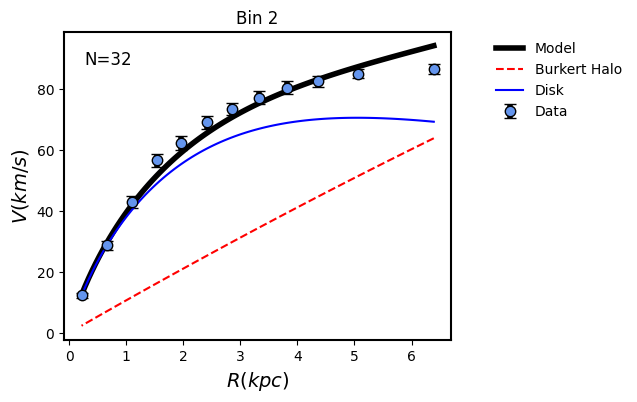

In [42]:
x=data[1]['r']*ropts[1]
y=data[1]['v']*vopts[1]
dy=data[1]['err']*vopts[1]
flat_samples=main(x,y,dy,ropts[1],vopts[1])
theta_max=np.mean(flat_samples,axis=0)
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))
plot_vels(1,theta_max)

100%|███████████████████████████████████████| 5000/5000 [02:48<00:00, 29.69it/s]


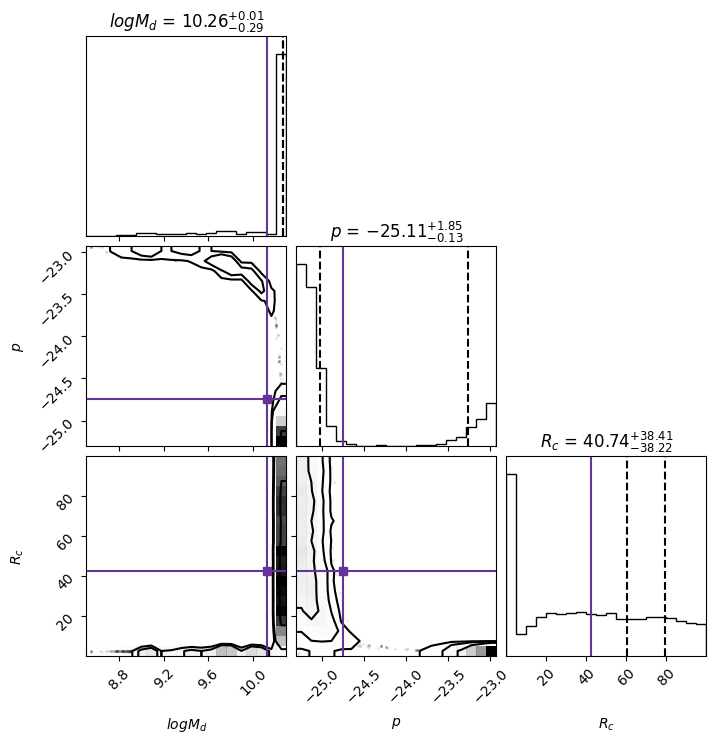

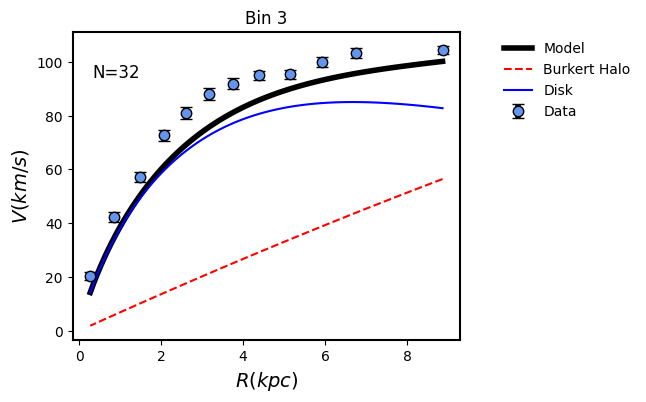

In [43]:
x=data[2]['r']*ropts[2]
y=data[2]['v']*vopts[2]
dy=data[2]['err']*vopts[2]
flat_samples=main(x,y,dy,ropts[2],vopts[2])
theta_max=np.mean(flat_samples,axis=0)
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))
plot_vels(2,theta_max)

100%|███████████████████████████████████████| 5000/5000 [02:51<00:00, 29.15it/s]


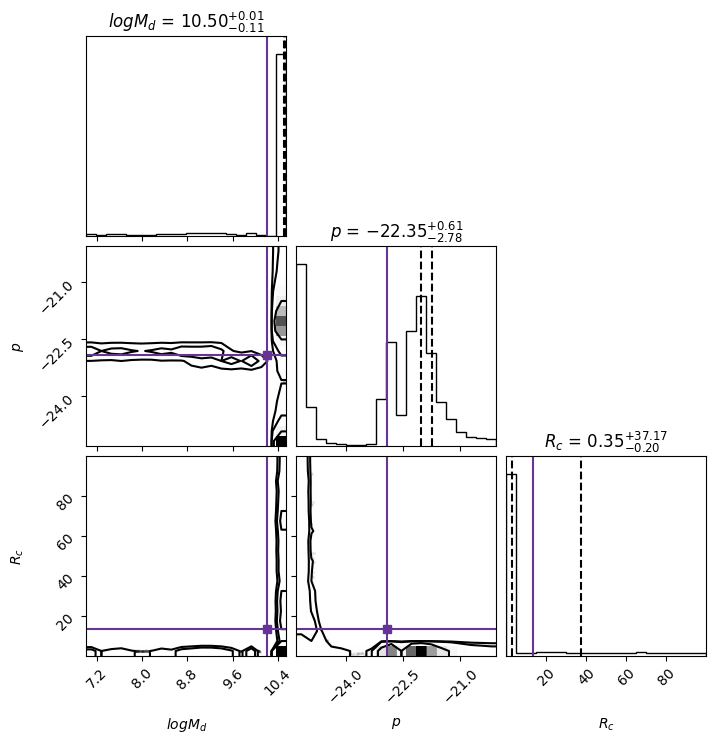

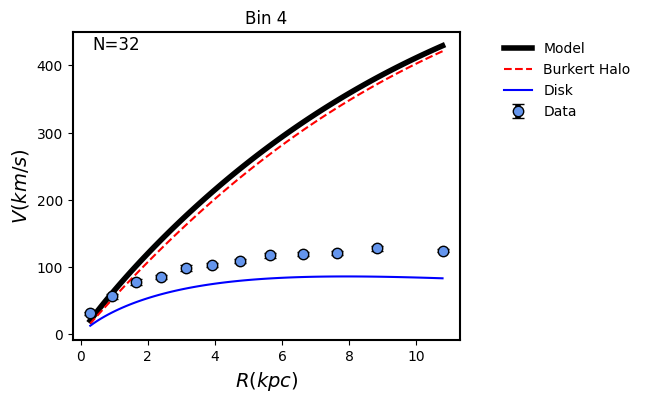

In [45]:
x=data[3]['r']*ropts[3]
y=data[3]['v']*vopts[3]
dy=data[3]['err']*vopts[3]
flat_samples=main(x,y,dy,ropts[3],vopts[3])
theta_max=np.mean(flat_samples,axis=0)
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))
plot_vels(3,theta_max)

100%|███████████████████████████████████████| 5000/5000 [03:13<00:00, 25.86it/s]


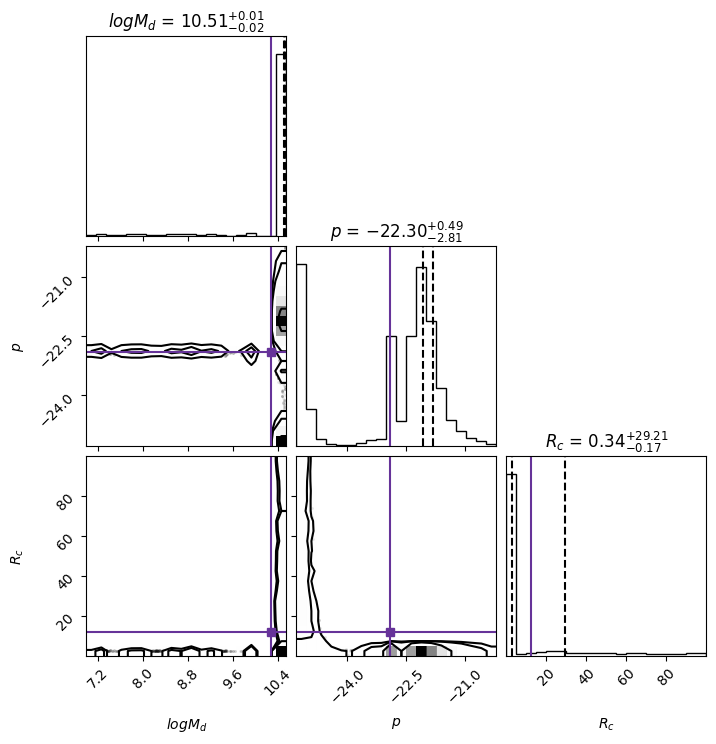

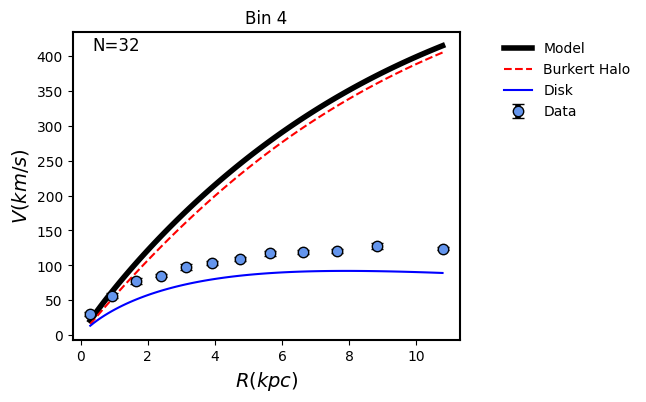

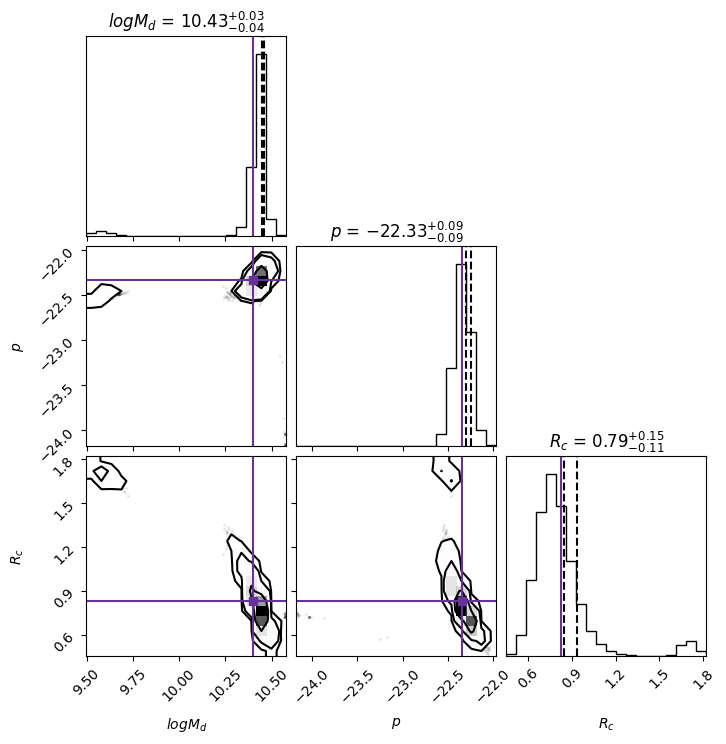

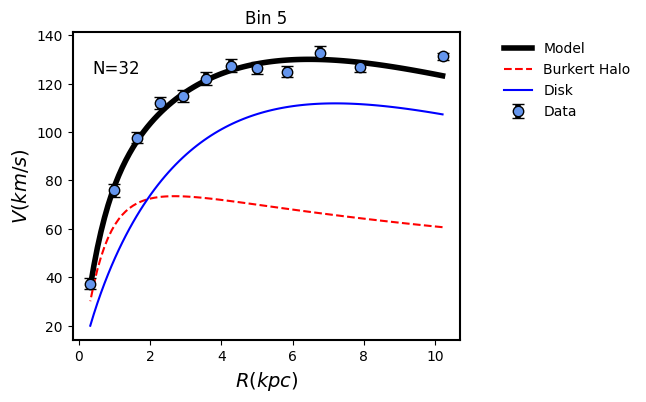

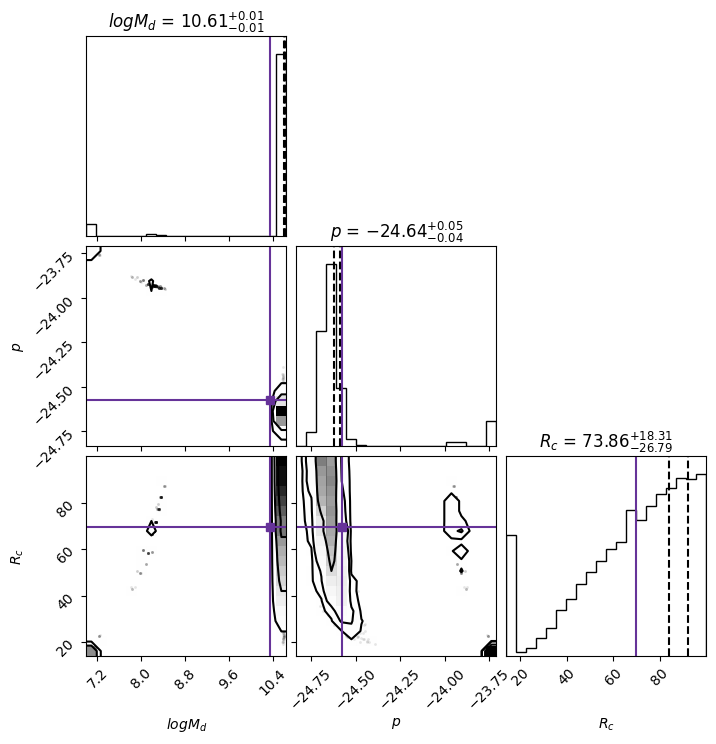

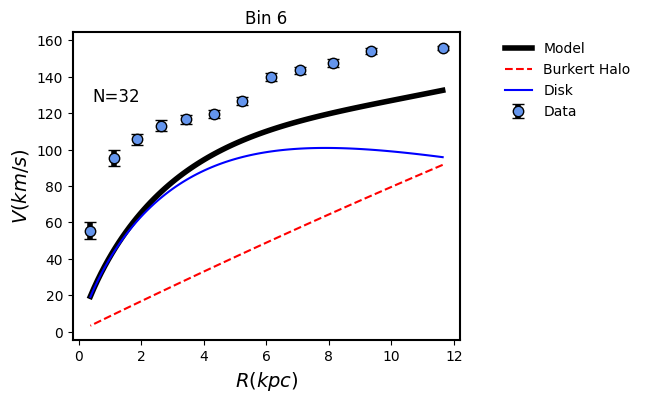

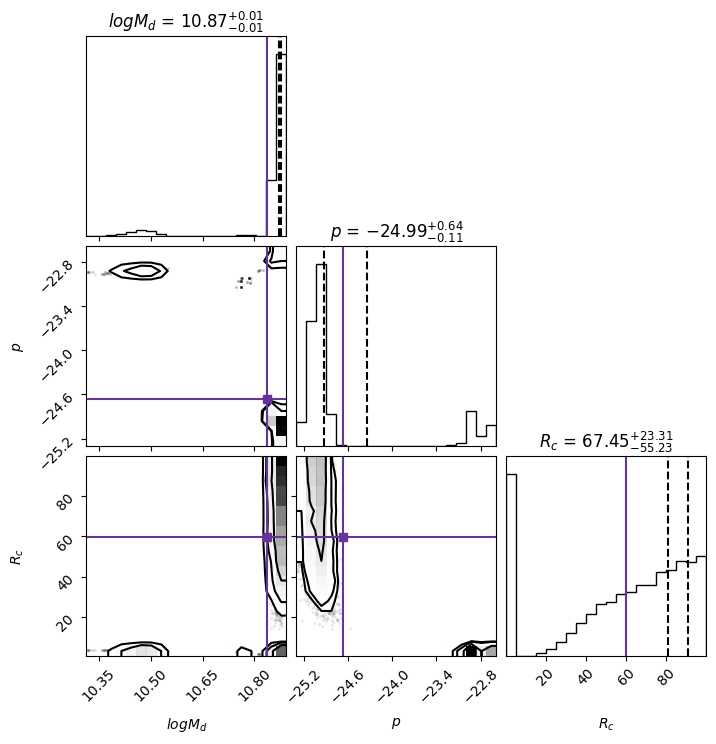

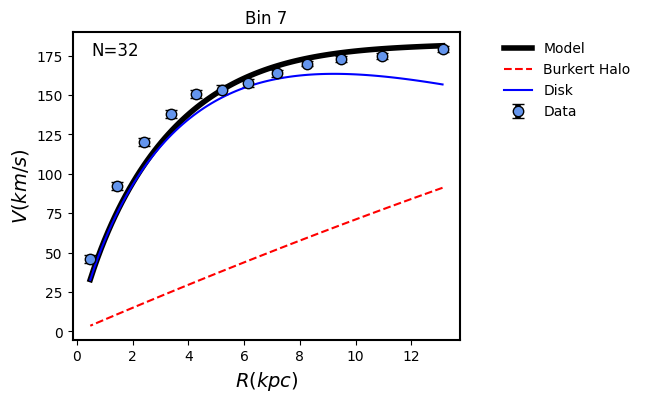

In [47]:
for i in range(4):
    no=i+3
    x=data[no]['r']*ropts[no]
    y=data[no]['v']*vopts[no]
    dy=data[no]['err']*vopts[no]
    flat_samples=main(x,y,dy,ropts[no],vopts[no])
    theta_max=np.mean(flat_samples,axis=0)
    fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))
    plot_vels(no,theta_max)

In [ ]:
no=7
x=data[no]['r']*ropts[no]
y=data[no]['v']*vopts[no]
dy=data[no]['err']*vopts[no]
flat_samples=main(x,y,dy,ropts[no],vopts[no])
theta_max=np.mean(flat_samples,axis=0)
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))

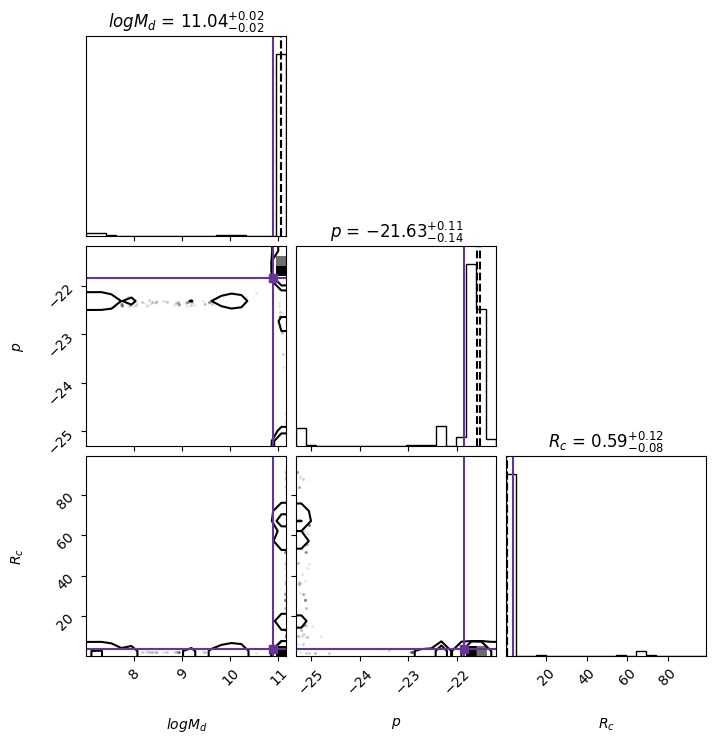

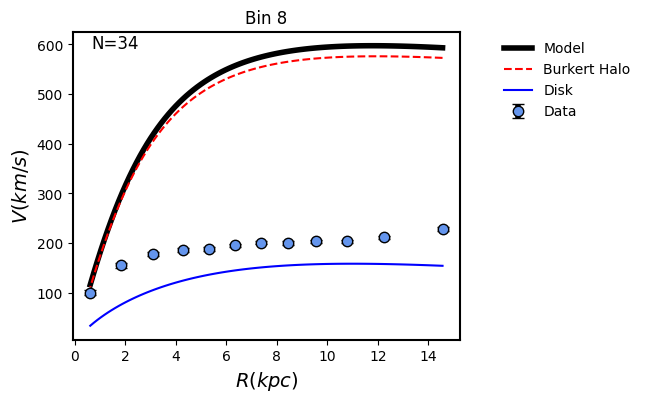

In [50]:
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))
plot_vels(no,theta_max)

## NFW

In [64]:
def nfw(theta,x, ropt,vopt):
    
    logmd,logp,rc=theta
    
    p=np.power(10,logp)

    return conv**2*1e-3*4*np.pi*p*(rc)**3*G/(x)*(np.log(1+(x/rc))-((x/rc)/(1+(x/rc)))) 

def model2(theta,x, ropt,vopt):
    
    logmd,logp,rc=theta
    
    return np.sqrt(
        nfw(theta,x, ropt,vopt)+disk(theta,x, ropt,vopt)
    )

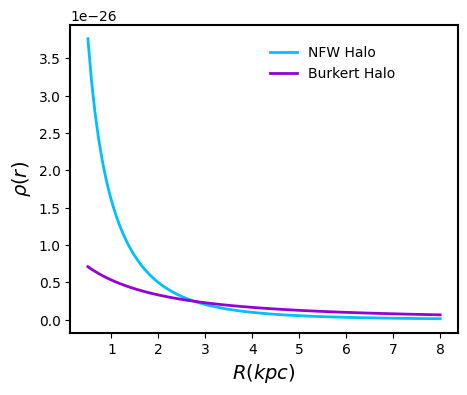

In [61]:
x=np.linspace(0.5,8,100)

def nfww(r, rho_0, r_c):
    
    r_over_r_c = r / r_c
    denominator = r_over_r_c * (1 + r_over_r_c ** 2)
    rho_value = rho_0 / denominator
    
    return rho_value

def burk(r, rho_0, r_c):
    
    denominator = (r + r_c) * (r + r_c ** 2)
    numerator = rho_0 * r_c ** 3
    rho_value = numerator / denominator
    
    return rho_value


fig,ax=plt.subplots(figsize=(5,4))
plt.plot(x,nfww(x,1e-26,2),color='deepskyblue',linewidth=2,label='NFW Halo')
plt.plot(x,burk(x,1e-26,2),color='darkviolet',linewidth=2,label='Burkert Halo')

plt.legend(frameon=False,loc=(0.5,0.8))
plt.xlabel('$R(kpc)$',fontsize=14,fontweight='bold')
plt.ylabel(r'$\rho(r)$',fontsize=14,fontweight='bold')
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

In [62]:
def log_likelihood2(theta, x, y, yerr,ropt,vopt):
    
    ymodel = model2(theta,x,ropt,vopt)

    return -0.5 * (np.sum((y - ymodel) ** 2 / (yerr**2))+np.sum(2*np.pi*yerr**2))

In [63]:
def log_probability2(theta, x, y, yerr,ropt,vopt):
    lp = log_prior(theta,ropt,vopt)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood2(theta, x, y, yerr,ropt,vopt)

In [65]:
def main2(x,y,yerr,ropt,vopt):
    
    
    p1=np.random.uniform(7,11+np.log10(8),25)
    #p2=np.random.uniform(5,11.5,25)
    p2=np.random.uniform(-26+np.log10(5),-20,25)
    p3=np.random.uniform(0,100,25)
    pos=np.vstack((p1,p2,p3)).T
    
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability2, args=(x, y, yerr,ropt,vopt))
    sampler.run_mcmc(pos, 5000, progress=True)
    
#    tau = sampler.get_autocorr_time()
    flat_samples = sampler.get_chain(discard=1000,thin=10, flat=True)
        
        
    return flat_samples

In [70]:
def plot_vels2(no,theta_max):
    
    xplot=data[no]['r']*ropts[no]
    yplot=data[no]['v']*vopts[no]
    dyplot=data[no]['err']*vopts[no]
    x=np.linspace(max(xplot),min(xplot),100)

    fig,ax=plt.subplots(figsize=(5,4))
    plt.errorbar(xplot,yplot,dyplot,fmt='.',markersize=15,elinewidth=4,markerfacecolor='cornflowerblue', 
             markeredgecolor='black', ecolor='black',color='black',capsize=4,label='Data')
    plt.plot(x,model2(theta_max,x,ropts[no],vopts[no]),linewidth=4,color='black',label='Model')
    plt.plot(x,np.sqrt(nfw(theta_max,x,ropts[no],vopts[no])),'--',color='red',label='NFW Halo')
    plt.plot(x,np.sqrt(disk(theta_max,x,ropts[no],vopts[no])),color='blue',label='Disk')

    if no<7:
        plt.text(x=min(xplot)+0.05,y=max(model2(theta_max,x,ropts[no],vopts[no]))-5,s='N=32',fontsize=12)
    else:
        plt.text(x=min(xplot)+0.05,y=max(model2(theta_max,x,ropts[no],vopts[no]))-5,s='N=34',fontsize=12)
        
    plt.legend(frameon=False,loc=(1.1,0.7))
    plt.xlabel('$R(kpc)$',fontsize=14,fontweight='bold')
    plt.ylabel('$V(km/s)$',fontsize=14,fontweight='bold')
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)

100%|███████████████████████████████████████| 5000/5000 [02:52<00:00, 28.96it/s]


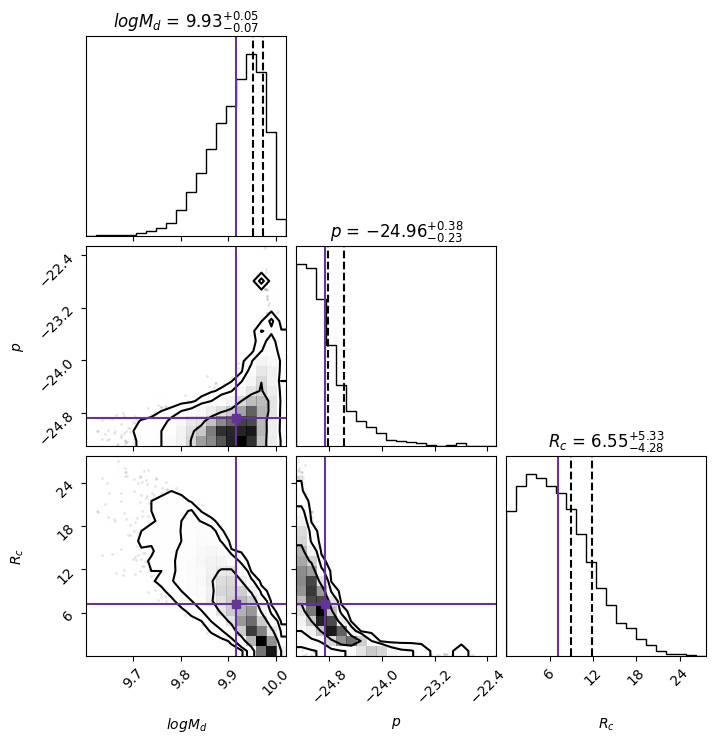

In [68]:
x=data[0]['r']*ropts[0]
y=data[0]['v']*vopts[0]
dy=data[0]['err']*vopts[0]
flat_samples=main2(x,y,dy,ropts[0],vopts[0])
theta_max=np.mean(flat_samples,axis=0)
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))

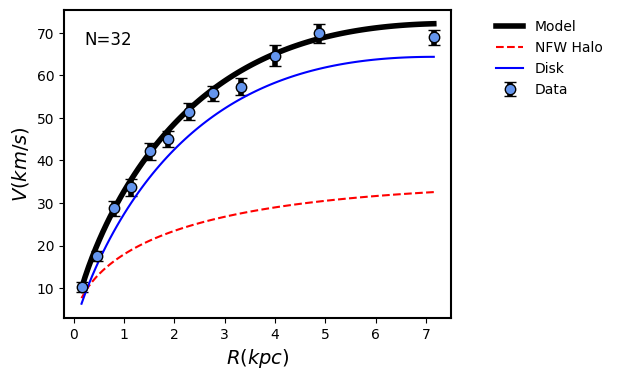

In [71]:
plot_vels2(0,theta_max)

100%|███████████████████████████████████████| 5000/5000 [02:30<00:00, 33.30it/s]


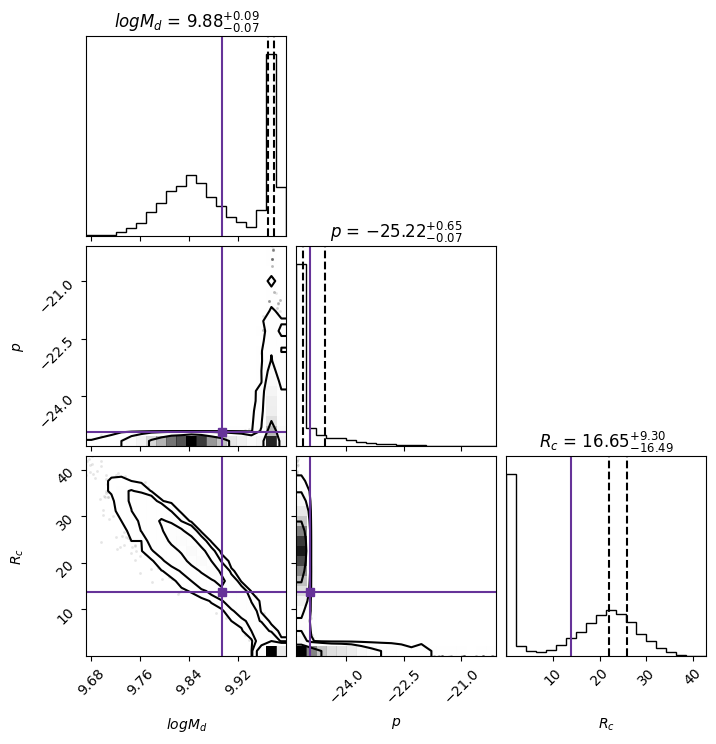

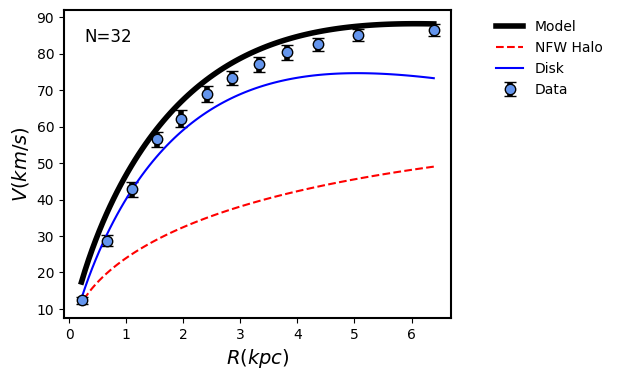

In [72]:
x=data[1]['r']*ropts[1]
y=data[1]['v']*vopts[1]
dy=data[1]['err']*vopts[1]
flat_samples=main2(x,y,dy,ropts[1],vopts[1])
theta_max=np.mean(flat_samples,axis=0)
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))
plot_vels2(1,theta_max)

100%|███████████████████████████████████████| 5000/5000 [03:20<00:00, 24.90it/s]


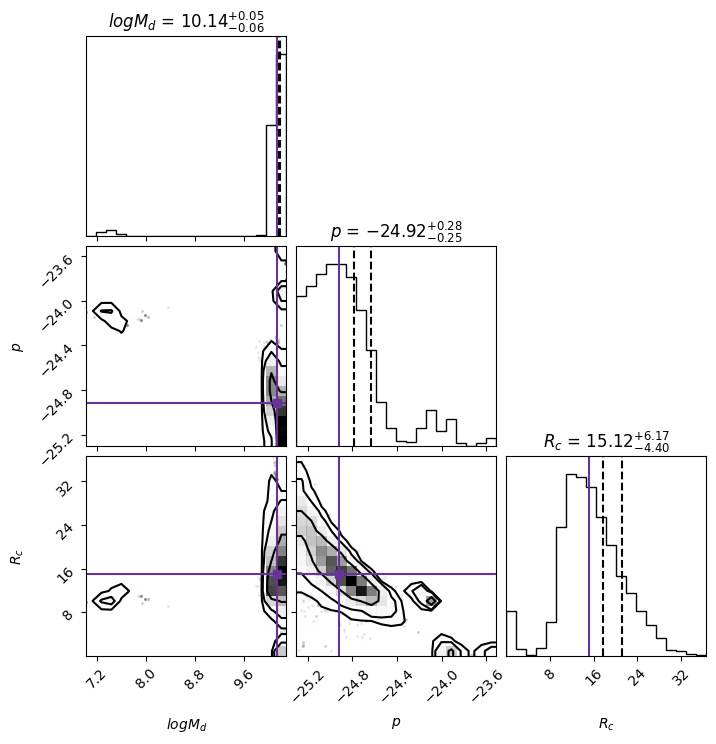

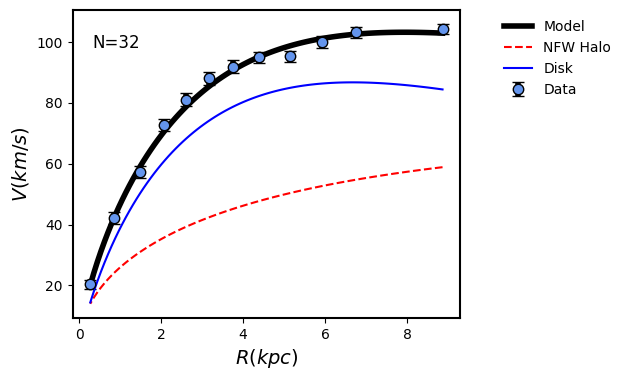

In [73]:
x=data[2]['r']*ropts[2]
y=data[2]['v']*vopts[2]
dy=data[2]['err']*vopts[2]
flat_samples=main2(x,y,dy,ropts[2],vopts[2])
theta_max=np.median(flat_samples,axis=0)
fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))
plot_vels2(2,theta_max)

100%|███████████████████████████████████████| 5000/5000 [02:49<00:00, 29.52it/s]


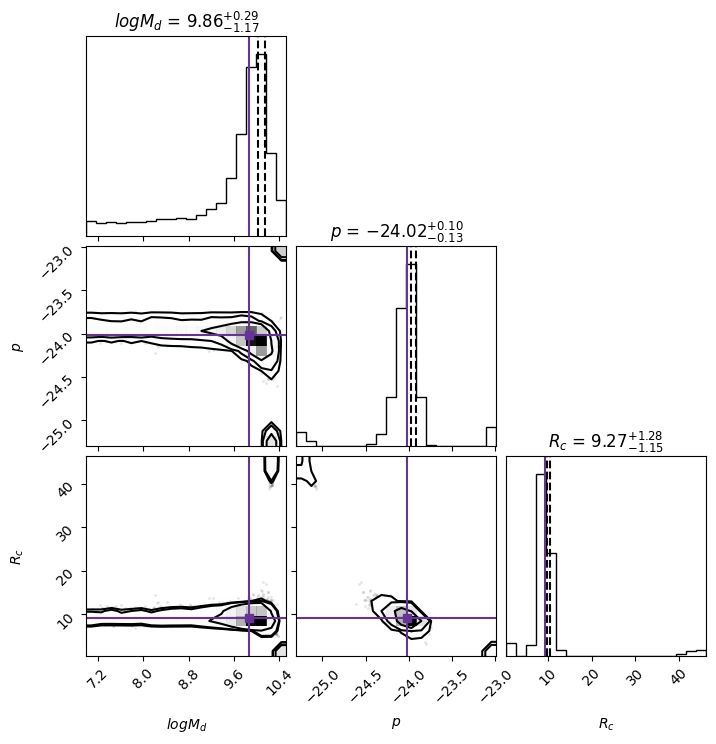

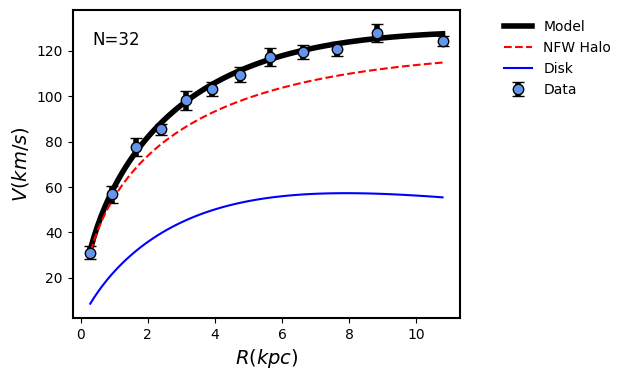

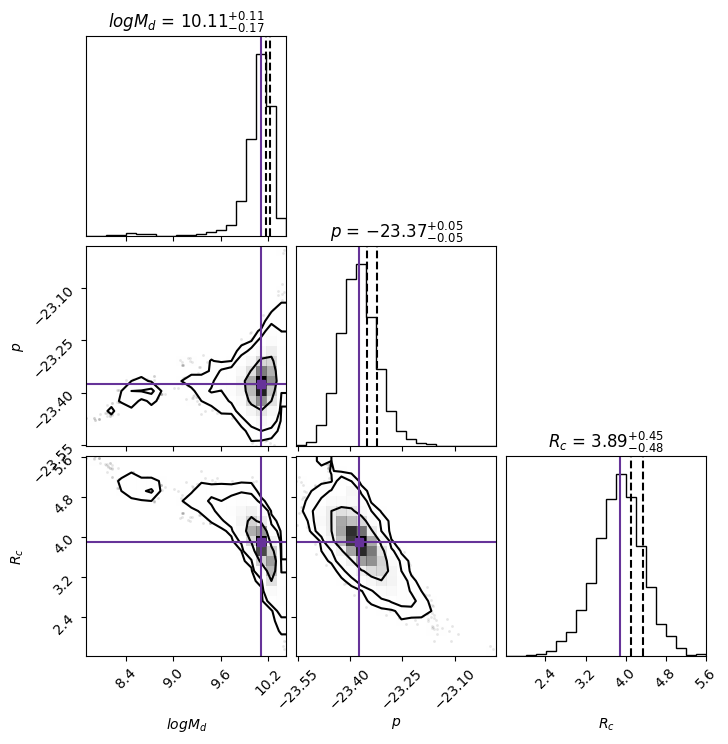

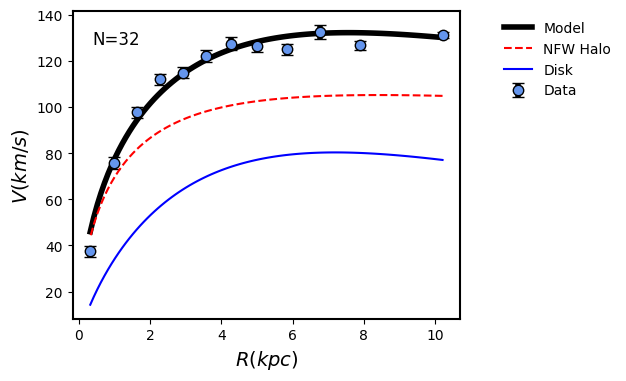

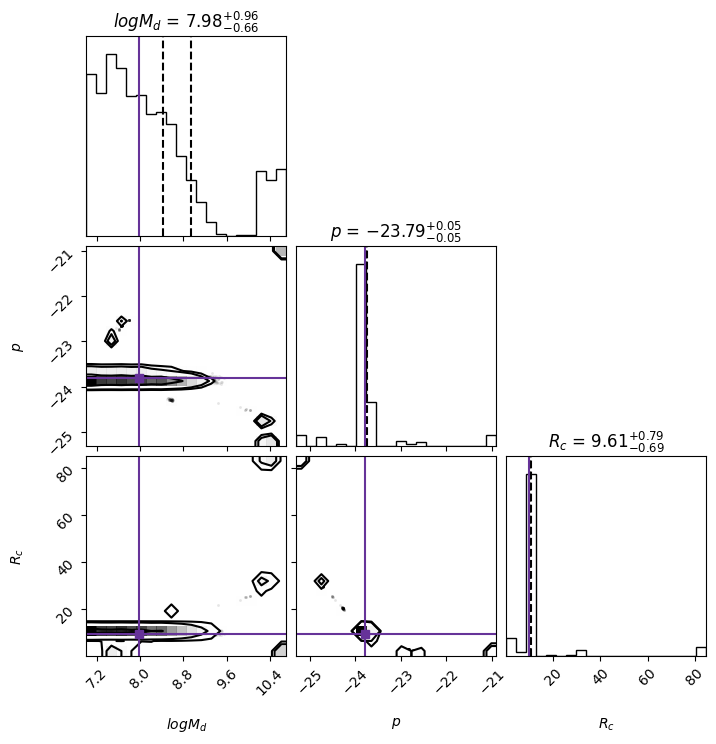

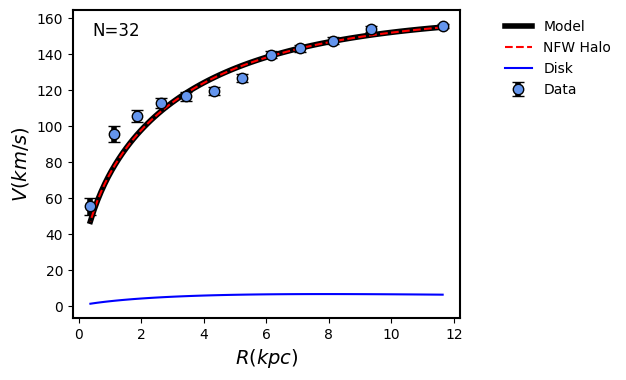

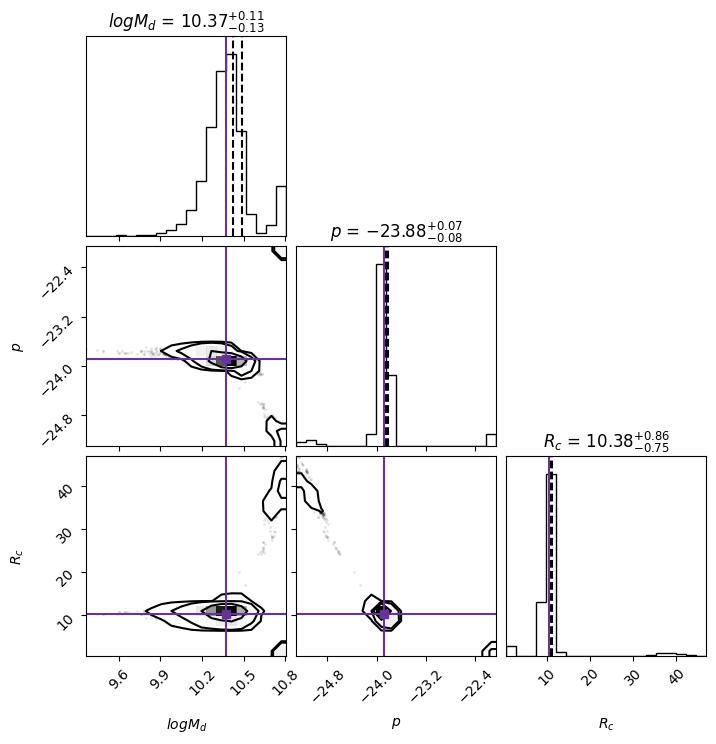

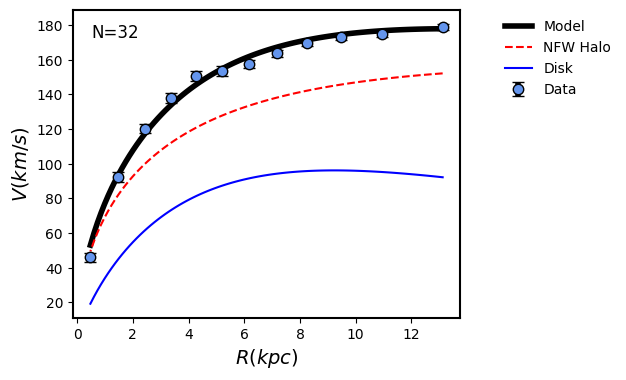

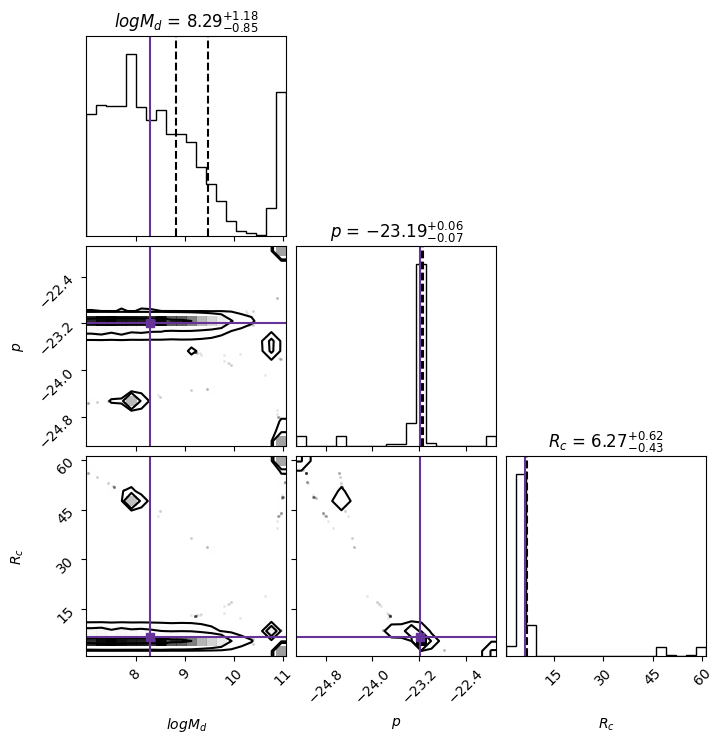

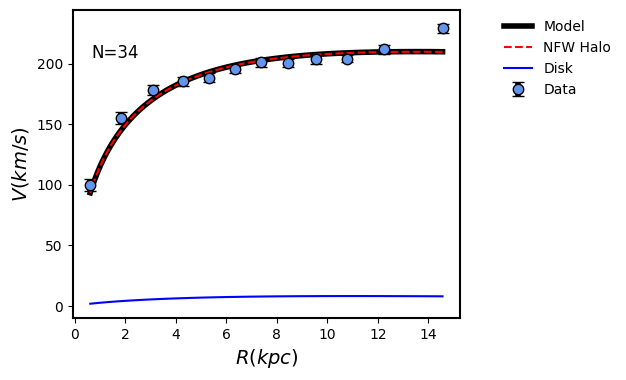

In [74]:
for i in range(5):
    no=i+3
    x=data[no]['r']*ropts[no]
    y=data[no]['v']*vopts[no]
    dy=data[no]['err']*vopts[no]
    flat_samples=main2(x,y,dy,ropts[no],vopts[no])
    theta_max=np.median(flat_samples,axis=0)
    fig = corner.corner(flat_samples,show_titles=True,labels=labels,truths=theta_max,truth_color='rebeccapurple',
                    quantiles=[0.68,0.84],levels=(0.68,0.95,0.99))
    plot_vels2(no,theta_max)